In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

from sklearn.linear_model import LogisticRegression,LinearRegression
from sklearn.preprocessing import StandardScaler
import lightgbm as lgb
import xgboost as xgb
from sklearn.model_selection import GridSearchCV,cross_val_score,StratifiedKFold,train_test_split
from sklearn.metrics import mean_squared_error,mean_absolute_error

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

#### Maybe this is related to the use of scatter plots instead of boxplots, which are more suitable for categorical variables visualization. The way we visualize data often influences our conclusions.

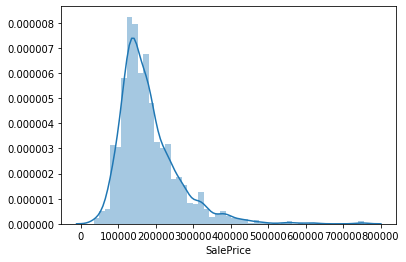

In [3]:
sns.distplot(train['SalePrice'])

#### Correlation matrix (heatmap style)

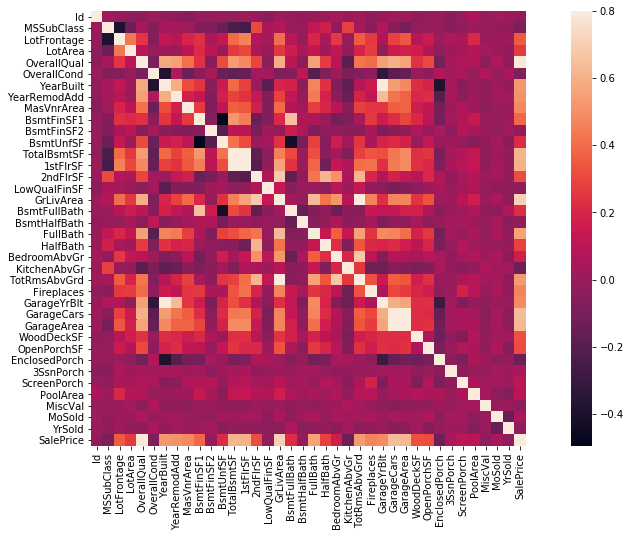

In [4]:
corrmat = train.corr()
f,ax = plt.subplots(figsize=(16,8))
sns.heatmap(corrmat,vmax=0.8, square=True)  

### SalePrice' correlation matrix (zoomed heatmap style)

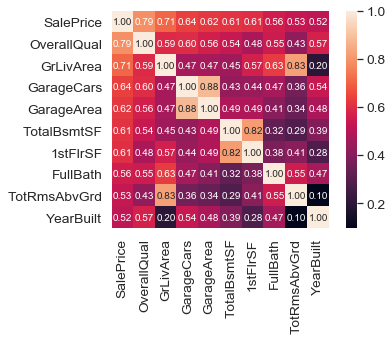

In [5]:
k = 10 # number of variables for matrix
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(train[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm,annot=True,square=True,fmt='.2f'
                 ,annot_kws={'size':10},yticklabels=cols.values,xticklabels=cols.values)


* 'OverallQual', 'GrLivArea' and 'TotalBsmtSF' are strongly correlated with 'SalePrice'. Check!
* 'GarageCars' and 'GarageArea' are also some of the most strongly correlated variables. However, as we discussed in the last sub-point, the number of cars that fit into the garage is a consequence of the garage area. 'GarageCars' and 'GarageArea' are like twin brothers. You'll never be able to distinguish them. Therefore, we just need one of these variables in our analysis (we can keep 'GarageCars' since its correlation with 'SalePrice' is higher).
* 'TotalBsmtSF' and '1stFloor' also seem to be twin brothers. 
* 'TotRmsAbvGrd' and 'GrLivArea', twin brothers again. 
* Ah... 'YearBuilt'... It seems that 'YearBuilt' is slightly correlated with 'SalePrice'. Honestly, it scares me to think about 'YearBuilt' because I start feeling that we should do a little bit of time-series analysis to get this right. 

### Scatter plots between 'SalePrice' and correlated variables

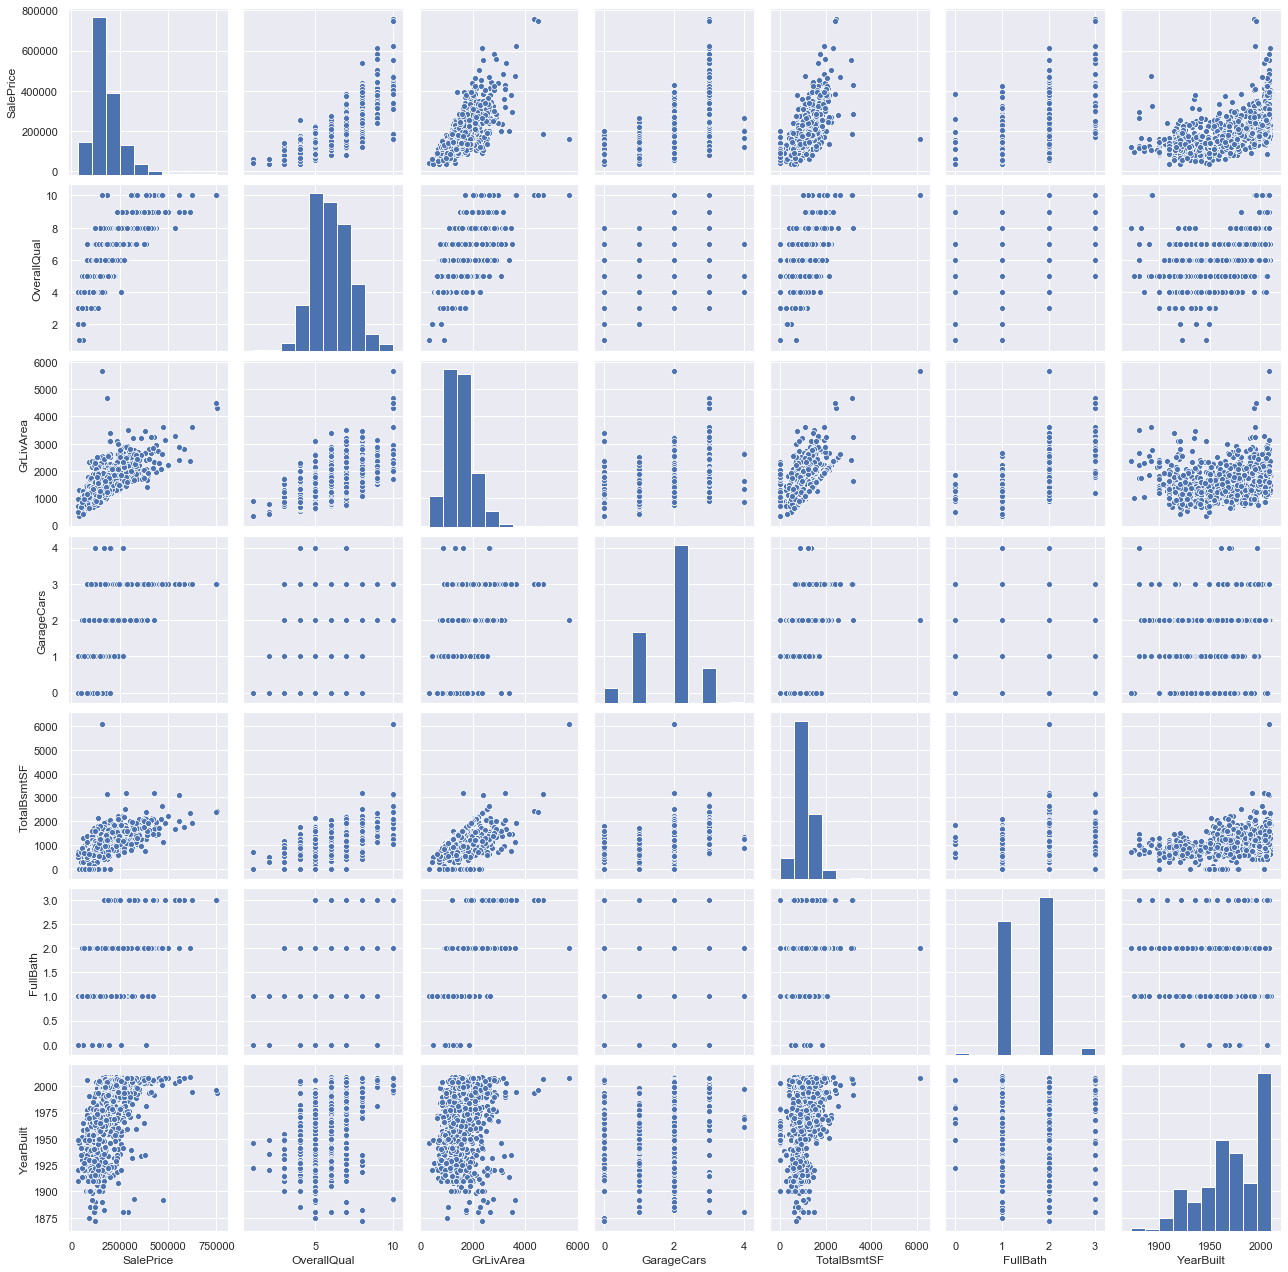

In [6]:
sns.set()
cols =['SalePrice','OverallQual','GrLivArea','GarageCars','TotalBsmtSF','FullBath','YearBuilt']
sns.pairplot(train[cols],size=2.5)

### handle missing data

In [7]:
total = train.isnull().sum().sort_values(ascending=False)
percent =(train.isnull().sum()/train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total,percent],axis=1,keys=['Total','Percent'])
missing_data.head(20)

,Total,Percent
PoolQC,1453,0.995205
MiscFeature,1406,0.963014
Alley,1369,0.937671
Fence,1179,0.807534
FireplaceQu,690,0.472603
LotFrontage,259,0.177397
GarageCond,81,0.055479
GarageType,81,0.055479
GarageYrBlt,81,0.055479
GarageFinish,81,0.055479


* We'll consider that more than 15% of the data is missing, we should delete the correspoding variable and pretend it never existed. This means that we will not try any trick to fill the missing data in these cases. According to this, there is a set of variables(e.g. 'PooIQC','MiscFeature','Alley',etc.)that we should delete. The point is :will we miss these data? I don't think so. None of these variables seem to be very important, since most of them are not aspects in which we think about when buying a house(maybe that's the reason why data is missing). Moreover, looking closer at the variables, we could say that variables like 'PooIQC','MiscFeature'and 'FireplaceQu' are strong candidates for outliers, so we'll be happy to delete them.

* We can see that 'GarageX' variables have the same number of missing data. I peculate that missing data refers to the same set of observations.Since the most important information regarding garages is expressed by 'GarageCars', I'll delete the mentioned 'GarageX' variables. The same logic applies to 'BsmtX' variables.

* We have one missing observation in 'Electrical'. Since it is just one observation, we'll delete this observation and keep the variable.

* For ther other variables, we consider that these variables are not essential.Furthermore, they have a strong correlation with 'YearBuilt' and 'OverallQual' which are already considered. Thus,we will not lose information if we delete other variables.

In [8]:
train = train.drop((missing_data[missing_data['Total']>1]).index,1)

In [9]:
train = train.drop(train.loc[train['Electrical'].isnull()].index)
train.isnull().sum().max()

0

* We look up in stack overflow website, when choosing Standardization method. Use StandardScaler if you know the data distribution is normal.If there are outliers, use RobustScaler(). Alternatively you could remove the outliers and use either of the above 2 scalers (choice depends on whether data is normally distributed)

### Out liars

#### Bivariate analysis

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


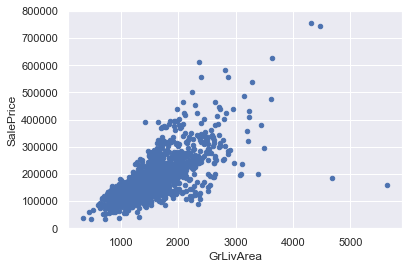

In [10]:
var = 'GrLivArea'
data = pd.DataFrame(train[var],columns=[var]).join(train['SalePrice'])
data.plot.scatter(x=var,y='SalePrice',ylim=(0,800000))

* The two values with bigger 'GrLivArea' seem strange and they are not following the crowd. We define them as outliers and delete them.

In [11]:
train.sort_values(by = 'GrLivArea', ascending = False)[:2]

,Id,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1298,1299,60,RL,63887,Pave,IR3,Bnk,AllPub,Corner,Gtl,...,0,0,0,480,0,1,2008,New,Partial,160000
523,524,60,RL,40094,Pave,IR1,Bnk,AllPub,Inside,Gtl,...,0,0,0,0,0,10,2007,New,Partial,184750


In [12]:
train = train.drop(train[train['Id'] == 1299].index)
train = train.drop(train[train['Id'] == 523].index)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


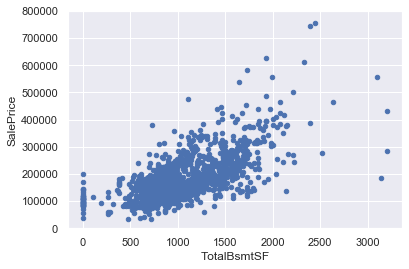

In [13]:
var = 'TotalBsmtSF'
data = pd.concat([train['SalePrice'],train[var]],axis=1)
data.plot.scatter(x=var,y='SalePrice',ylim=(0,800000))

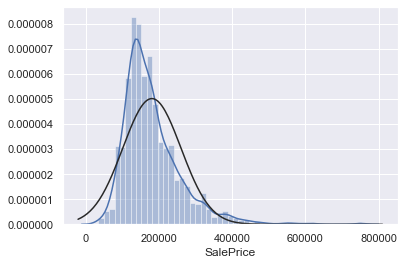

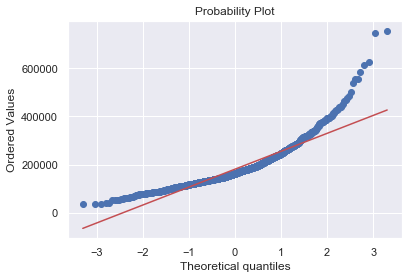

In [14]:
# histogram and normal probability plot
sns.distplot(train['SalePrice'],fit =norm)
fig = plt.figure()
res = stats.probplot(train['SalePrice'],plot=plt)

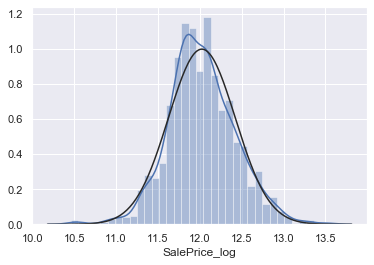

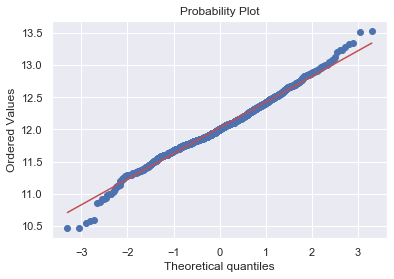

In [15]:
# applying log transformation
train['SalePrice_log']= np.log(train['SalePrice'])
sns.distplot(train['SalePrice_log'],fit=norm)
fig=plt.figure()
res=stats.probplot(train['SalePrice_log'],plot =plt)

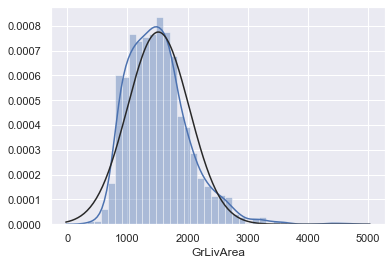

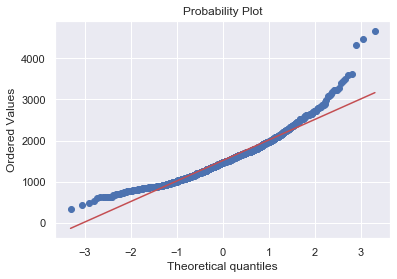

In [16]:
sns.distplot(train['GrLivArea'], fit=norm);
plt.figure()
res = stats.probplot(train['GrLivArea'], plot=plt)

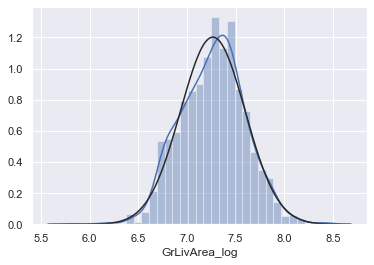

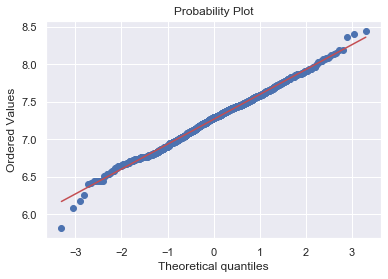

In [17]:
train['GrLivArea_log'] = np.log(train['GrLivArea'])

sns.distplot(train['GrLivArea_log'],fit = norm)
plt.figure()
res = stats.probplot(train['GrLivArea_log'],plot=plt)

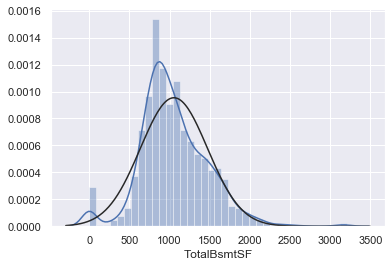

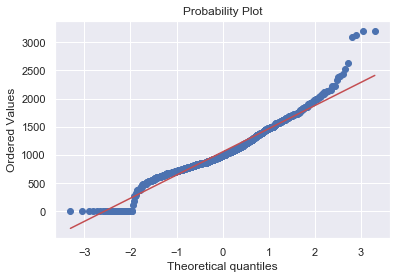

In [18]:
sns.distplot(train['TotalBsmtSF'],fit=norm)
plt.figure()
res = stats.probplot(train['TotalBsmtSF'],plot = plt)

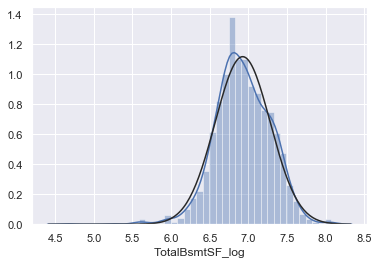

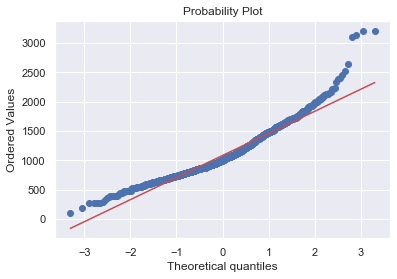

In [19]:
train['TotalBsmtSF_log'] = np.log(train['TotalBsmtSF']+1)


sns.distplot(train[train['TotalBsmtSF_log']> 0]['TotalBsmtSF_log'],fit = norm)
plt.figure()
res = stats.probplot(train[train['TotalBsmtSF_log']>0]['TotalBsmtSF'],plot=plt)

###  training model xgboost and lightGBM

* There's no need for standardizing the training set, because the model we choose does not necessarily need this step.

In [20]:
train

,Id,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,SalePrice_log,GrLivArea_log,TotalBsmtSF_log
0,1,60,RL,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,2,2008,WD,Normal,208500,12.247694,7.444249,6.753438
1,2,20,RL,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,...,0,0,5,2007,WD,Normal,181500,12.109011,7.140453,7.141245
2,3,60,RL,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,0,0,9,2008,WD,Normal,223500,12.317167,7.487734,6.825460
3,4,70,RL,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,0,0,2,2006,WD,Abnorml,140000,11.849398,7.448334,6.629363
4,5,60,RL,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,...,0,0,12,2008,WD,Normal,250000,12.429216,7.695303,7.044033
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,7917,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,8,2007,WD,Normal,175000,12.072541,7.406711,6.860664
1456,1457,20,RL,13175,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,2,2010,WD,Normal,210000,12.254863,7.636752,7.341484
1457,1458,70,RL,9042,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,2500,5,2010,WD,Normal,266500,12.493130,7.757906,7.050123
1458,1459,20,RL,9717,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,4,2010,WD,Normal,142125,11.864462,6.982863,6.983790


In [21]:
X = pd.DataFrame(train,columns=['OverallQual','GrLivArea','GarageCars','TotalBsmtSF','FullBath','YearBuilt'])
y = train['SalePrice_log'].copy()
y

0       12.247694
1       12.109011
2       12.317167
3       11.849398
4       12.429216
          ...    
1455    12.072541
1456    12.254863
1457    12.493130
1458    11.864462
1459    11.901583
Name: SalePrice_log, Length: 1457, dtype: float64

In [25]:
y.isnull().sum()

0

In [22]:
y.shape

(1457,)

In [25]:
X_test_Id = test[['Id','OverallQual','GrLivArea','GarageCars','TotalBsmtSF','FullBath','YearBuilt']]
print('X_train shape:',X.shape)
print('X_test shape:',X_test_Id.shape)

X_train shape: (1457, 6)
X_test shape: (1459, 7)


In [26]:
X_test_Id.isnull().sum()

Id             0
OverallQual    0
GrLivArea      0
GarageCars     1
TotalBsmtSF    1
FullBath       0
YearBuilt      0
dtype: int64

### handling testset missing value

In [27]:
X_test_Id['GarageCars'] = X_test_Id['GarageCars'].fillna(np.mean(X_test_Id['GarageCars']))
X_test_Id['TotalBsmtSF'] = X_test_Id['TotalBsmtSF'].fillna(np.mean(X_test_Id['TotalBsmtSF']))
X_test = X_test_Id.iloc[:,1:]

In [29]:
X_test.isnull().sum()

OverallQual    0
GrLivArea      0
GarageCars     0
TotalBsmtSF    0
FullBath       0
YearBuilt      0
dtype: int64

In [30]:
x_train,x_val,y_train,y_val = train_test_split(X,y,test_size=0.3)

In [31]:
def build_model_xgb(x_train,y_train):
    model = xgb.XGBRegressor(n_estimators=150,learning_rate = 0.1, ganmma=0,subsample=0.8,\
                            colsample_bytress=0.9,max_depth=7)
    model.fit(x_train,y_train)
    return model
def build_model_lgb(x_train,y_train):
    estimator = lgb.LGBMRegressor(num_leaves=127,n_estimators=150)
    param_grid ={
        'learning_rate':[0.01,0.05,0.1,0.2]
    }
    gbm = GridSearchCV(estimator,param_grid)
    gbm.fit(x_train,y_train)
    return gbm

In [32]:
print('Train lgb...')
model_lgb = build_model_lgb(x_train,y_train)
val_lgb = model_lgb.predict(x_val)
MAE_lgb = mean_absolute_error(y_val,val_lgb)
print('MAE of val with lgb:', MAE_lgb)

print('Predict lgb...')
model_lgb_pre = build_model_lgb(X,y)
subA_lgb = model_lgb_pre.predict(X_test)

print('Train xgb...')
model_xgb = build_model_xgb(x_train,y_train)
val_xgb = model_xgb.predict(x_val)
MAE_xgb = mean_absolute_error(y_val,val_xgb)
print('MAE of val with xgb:',MAE_xgb)

print('Predict xgb...')
model_xgb_pre = build_model_xgb(X,y)
subA_xgb = model_xgb_pre.predict(X_test)

Train lgb...
MAE of val with lgb: 0.12029670054898181
Predict lgb...
Train xgb...
MAE of val with xgb: 0.12226246349874294
Predict xgb...


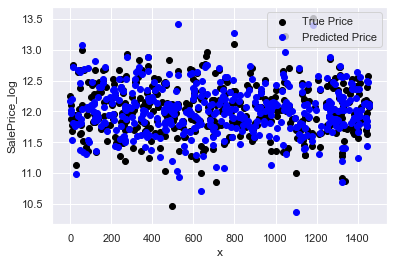

In [33]:
plt.scatter(x_val.index, y_val, color='black')
plt.scatter(x_val.index, val_xgb, color='blue')
plt.xlabel('x')
plt.ylabel('SalePrice_log')
plt.legend(['True Price','Predicted Price'],loc='upper right')

### Merge models through simple weighted

In [34]:
val_Weighted = (1-MAE_lgb/(MAE_xgb+MAE_lgb))*val_lgb+(1-MAE_xgb/(MAE_xgb+MAE_lgb))*val_xgb
val_Weighted[val_Weighted<0]=10
print('MAE of val with Weighted ensemble:',mean_absolute_error(y_val,val_Weighted))

MAE of val with Weighted ensemble: 0.11851404614179574


In [35]:
sub_Weighted = (1-MAE_lgb/(MAE_xgb+MAE_lgb))*subA_lgb+(1-MAE_xgb/(MAE_xgb+MAE_lgb))*subA_xgb

sub = pd.DataFrame()
sub['Id'] = X_test_Id['Id']
sub['SalePrice'] = np.exp(sub_Weighted)
sub.to_csv('./sub_Weighted.csv',index=False)
sub

,Id,SalePrice
0,1461,120664.320195
1,1462,149789.881230
2,1463,166107.632733
3,1464,181135.363745
4,1465,193834.967218
...,...,...
1454,2915,75876.067165
1455,2916,83202.941736
1456,2917,138804.876131
1457,2918,109523.308248


### Each person's contribution
* Claire-Jingtong Peng have done most of the Exploratory data analysis, and choose some strongly correlated features and data preprocessing.
* While I use the xgboost and lightgbm model for training the dataset, it does not seem perform very well.

* On the other hand,Long_ZhangDelong choose all the features and use the GradientBoostingRegressor model to train this dataset. Suprisingly,it performs better than Claire did, according to the mae value is smaller. He also use other model such as LinearRegression, RandomForest etc, but all of them are not better than GBR model.

![image.jpg](./1589204721(1).jpg)

* This EDA part is manly done by Gemma-Zhuoman Li, He's tring to analysis the training_data and correlation between SalePrice and all the features.

![image.jpg](./1589205542(1).jpg)